In [1]:
# import packages
import os
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy.plot as ep

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

os.getcwd()

'f:\\helene\\RF_Classification-Darcy\\RF_Classification'

In [2]:
# Read in training data shapefile
shp = gpd.read_file('./data/asheville_9_20.shp')
print(len(shp))
shp.head()

76


,id,Class,Notes,geometry
0,3,1,None,"POLYGON ((357933 3938826, 357954 3938826, 3579..."
1,1,1,None,"POLYGON ((357984 3938892, 357987 3938892, 3579..."
2,2,1,None,"POLYGON ((357927 3938640, 357936 3938640, 3579..."
3,4,0,None,"POLYGON ((356496 3938838, 357111 3938142, 3570..."
4,5,0,None,"POLYGON ((356661 3939951, 357276 3939003, 3572..."


In [3]:
# Read in PS image and check number of bands
ps_bands = rio.open('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif')
ps_stack = ps_bands.read()
print(ps_stack.shape, ps_stack.dtype, type(ps_stack))

(4, 9112, 12528) uint16 <class 'numpy.ndarray'>


In [4]:
# Check crs of bands and shapefile
shp = shp.to_crs('EPSG:32617')
print(ps_bands.crs)
print(shp.crs)

EPSG:32617
EPSG:32617


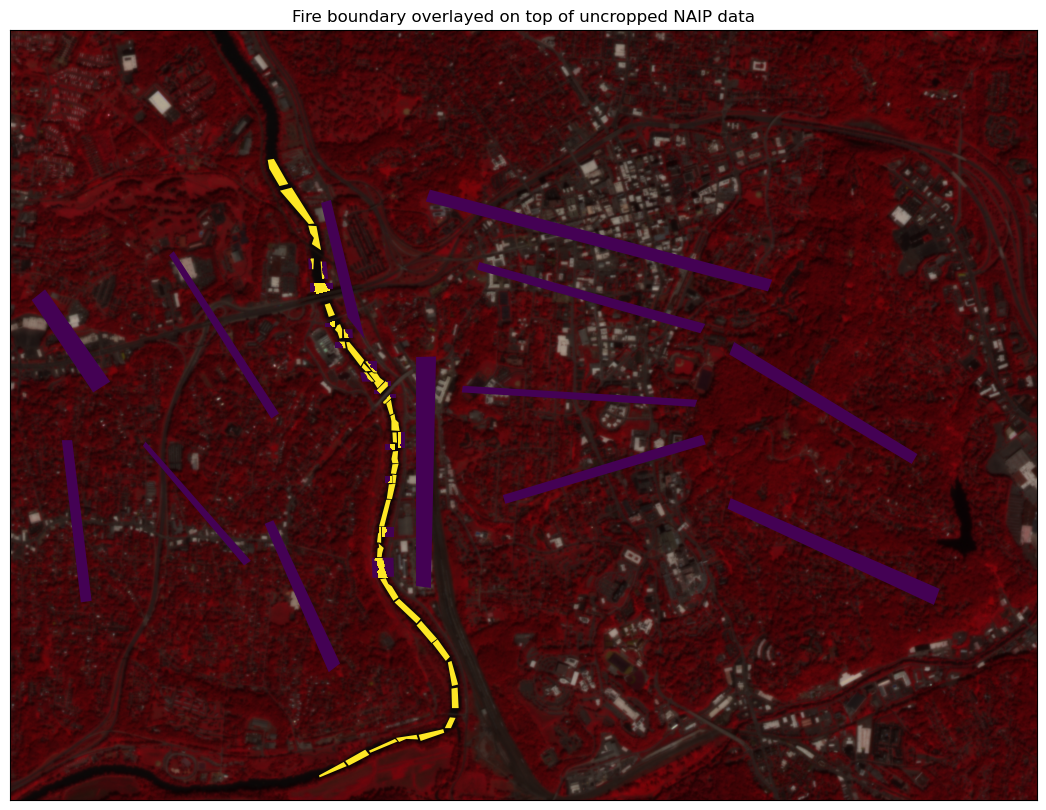

In [5]:
# Plot polygons over raster
import rioxarray as rxr

image = rxr.open_rasterio('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif', masked=True)
clipped_image = image[:, 2250:3750, 6500:8500]
ps_plotting_extent = plotting_extent(clipped_image[0], clipped_image.rio.transform())

# Plot uncropped array
f, ax = plt.subplots(figsize=(15,10))

ep.plot_rgb(clipped_image.values,
            rgb=[3, 2, 1],
            ax=ax,
            title="Fire boundary overlayed on top of uncropped NAIP data",
            extent=ps_plotting_extent) 

shp.plot(column='Class', ax=ax)

plt.show()

In [6]:
clipped_image

<xarray.DataArray (band: 4, y: 1500, x: 2000)> Size: 48MB
array([[[ 553.,  440., ...,  178.,  203.],
        [ 601.,  487., ...,  221.,  254.],
        ...,
        [ 220.,  217., ...,  104.,  114.],
        [ 225.,  219., ...,   80.,   71.]],

       [[ 783.,  734., ...,  442.,  442.],
        [ 866.,  803., ...,  462.,  477.],
        ...,
        [ 533.,  535., ...,  325.,  305.],
        [ 526.,  538., ...,  279.,  265.]],

       [[ 782.,  719., ...,  297.,  336.],
        [ 926.,  827., ...,  346.,  401.],
        ...,
        [ 335.,  337., ...,  218.,  242.],
        [ 331.,  333., ...,  206.,  188.]],

       [[3228., 3265., ..., 2946., 3120.],
        [3080., 3221., ..., 3070., 3241.],
        ...,
        [4089., 4209., ..., 2703., 2768.],
        [4058., 4241., ..., 2662., 2604.]]],
      shape=(4, 1500, 2000), dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 16kB 3.557e+05 3.557e+05 ... 3.617e+05 3.617e+05
  * y            (y) float64 12kB 3.941e+06 3.941e+06 ... 3.937e+06 3.937e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2024:09:20 16:25:15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir')

### Add Normalized Difference Water Index

In [7]:
#  NDWI = (GREEN - NIR) / (GREEN + NIR)        
ndwi = (clipped_image[1] - clipped_image[3]) / (clipped_image[1] + clipped_image[3])

### Add Normalized Difference Vegetation Index

In [8]:
# NDVI = (NIR - RED) / (NIR + RED)
ndvi = (clipped_image[3] - clipped_image[2]) / (clipped_image[3] + clipped_image[2])

### Add Normalized Difference Impervious Surface Index (Su et al., 2022)

In [9]:
# NISI = ( (BLUE + GREEN + RED) - NIR ) / ( (BLUE + GREEN + RED) + NIR )
nisi = ((clipped_image[0] + clipped_image[1] + clipped_image[2]) - clipped_image[3]) / ((clipped_image[0] + clipped_image[1] + clipped_image[2]) + clipped_image[3])

# Stack NDWI and NDVI onto PS Bands

In [10]:
import xarray as xr

In [11]:
# index_lst = 

index_stack = xr.concat([ndwi, ndvi, nisi], dim='band')

PS_stack = xr.concat([
    clipped_image[0:4],
    index_stack.assign_coords({'band':['ndwi', 'ndvi', 'nisi']})
],
dim='band')

# PS_stack = xr.concat([
#     PS_stack[0:5],
#     ndvi.assign_coords({'band':'ndvi'})
# ],
# dim='band')
PS_stack

<xarray.DataArray (band: 7, y: 1500, x: 2000)> Size: 84MB
array([[[ 5.5300000e+02,  4.4000000e+02,  4.0600000e+02, ...,
          1.5400000e+02,  1.7800000e+02,  2.0300000e+02],
        [ 6.0100000e+02,  4.8700000e+02,  4.3100000e+02, ...,
          1.8200000e+02,  2.2100000e+02,  2.5400000e+02],
        [ 6.1800000e+02,  5.1000000e+02,  4.6300000e+02, ...,
          2.0500000e+02,  2.5100000e+02,  2.9200000e+02],
        ...,
        [ 2.1200000e+02,  2.1400000e+02,  1.9400000e+02, ...,
          1.2300000e+02,  1.2900000e+02,  1.3100000e+02],
        [ 2.2000000e+02,  2.1700000e+02,  2.0000000e+02, ...,
          1.0000000e+02,  1.0400000e+02,  1.1400000e+02],
        [ 2.2500000e+02,  2.1900000e+02,  2.1200000e+02, ...,
          9.8000000e+01,  8.0000000e+01,  7.1000000e+01]],

       [[ 7.8300000e+02,  7.3400000e+02,  6.7400000e+02, ...,
          3.6800000e+02,  4.4200000e+02,  4.4200000e+02],
        [ 8.6600000e+02,  8.0300000e+02,  7.2500000e+02, ...,
          3.8700000e+02,  4.6200000e+02,  4.7700000e+02],
        [ 8.8600000e+02,  8.2000000e+02,  7.3800000e+02, ...,
          4.0100000e+02,  4.7700000e+02,  5.2900000e+02],
...
          8.4600699e-01,  8.3161515e-01,  8.1475353e-01],
        [ 8.4855336e-01,  8.5173780e-01,  8.5714287e-01, ...,
          8.4665793e-01,  8.5073602e-01,  8.3920264e-01],
        [ 8.4916836e-01,  8.5439438e-01,  8.5597944e-01, ...,
          8.4106845e-01,  8.5634589e-01,  8.6532950e-01]],

       [[-2.0763187e-01, -2.6599458e-01, -3.0424434e-01, ...,
         -5.5605632e-01, -5.2523947e-01, -5.2158010e-01],
        [-1.2552531e-01, -2.0681903e-01, -2.7903411e-01, ...,
         -5.2339017e-01, -4.9792632e-01, -4.8227760e-01],
        [-7.0729457e-02, -1.8507573e-01, -2.6321775e-01, ...,
         -5.1702785e-01, -4.8357666e-01, -4.4377422e-01],
        ...,
        [-5.8505255e-01, -5.8802074e-01, -5.9557968e-01, ...,
         -6.0143530e-01, -5.6396711e-01, -5.6832474e-01],
        [-5.7967937e-01, -5.8890146e-01, -6.0120165e-01, ...,
         -6.2937266e-01, -6.1373132e-01, -6.1446488e-01],
        [-5.7898831e-01, -5.9107107e-01, -5.9896600e-01, ...,
         -6.3184375e-01, -6.4982957e-01, -6.6496164e-01]]],
      shape=(7, 1500, 2000), dtype=float32)
Coordinates:
  * band         (band) <U21 588B '1' '2' '3' '4' 'ndwi' 'ndvi' 'nisi'
  * x            (x) float64 16kB 3.557e+05 3.557e+05 ... 3.617e+05 3.617e+05
  * y            (y) float64 12kB 3.941e+06 3.941e+06 ... 3.937e+06 3.937e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2024:09:20 16:25:15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir')

In [12]:
PS_stack.attrs['long_name'] = ('blue', 'green', 'red', 'nir', 'ndwi', 'ndvi', 'nisi')

In [13]:
PS_stack

<xarray.DataArray (band: 7, y: 1500, x: 2000)> Size: 84MB
array([[[ 5.5300000e+02,  4.4000000e+02,  4.0600000e+02, ...,
          1.5400000e+02,  1.7800000e+02,  2.0300000e+02],
        [ 6.0100000e+02,  4.8700000e+02,  4.3100000e+02, ...,
          1.8200000e+02,  2.2100000e+02,  2.5400000e+02],
        [ 6.1800000e+02,  5.1000000e+02,  4.6300000e+02, ...,
          2.0500000e+02,  2.5100000e+02,  2.9200000e+02],
        ...,
        [ 2.1200000e+02,  2.1400000e+02,  1.9400000e+02, ...,
          1.2300000e+02,  1.2900000e+02,  1.3100000e+02],
        [ 2.2000000e+02,  2.1700000e+02,  2.0000000e+02, ...,
          1.0000000e+02,  1.0400000e+02,  1.1400000e+02],
        [ 2.2500000e+02,  2.1900000e+02,  2.1200000e+02, ...,
          9.8000000e+01,  8.0000000e+01,  7.1000000e+01]],

       [[ 7.8300000e+02,  7.3400000e+02,  6.7400000e+02, ...,
          3.6800000e+02,  4.4200000e+02,  4.4200000e+02],
        [ 8.6600000e+02,  8.0300000e+02,  7.2500000e+02, ...,
          3.8700000e+02,  4.6200000e+02,  4.7700000e+02],
        [ 8.8600000e+02,  8.2000000e+02,  7.3800000e+02, ...,
          4.0100000e+02,  4.7700000e+02,  5.2900000e+02],
...
          8.4600699e-01,  8.3161515e-01,  8.1475353e-01],
        [ 8.4855336e-01,  8.5173780e-01,  8.5714287e-01, ...,
          8.4665793e-01,  8.5073602e-01,  8.3920264e-01],
        [ 8.4916836e-01,  8.5439438e-01,  8.5597944e-01, ...,
          8.4106845e-01,  8.5634589e-01,  8.6532950e-01]],

       [[-2.0763187e-01, -2.6599458e-01, -3.0424434e-01, ...,
         -5.5605632e-01, -5.2523947e-01, -5.2158010e-01],
        [-1.2552531e-01, -2.0681903e-01, -2.7903411e-01, ...,
         -5.2339017e-01, -4.9792632e-01, -4.8227760e-01],
        [-7.0729457e-02, -1.8507573e-01, -2.6321775e-01, ...,
         -5.1702785e-01, -4.8357666e-01, -4.4377422e-01],
        ...,
        [-5.8505255e-01, -5.8802074e-01, -5.9557968e-01, ...,
         -6.0143530e-01, -5.6396711e-01, -5.6832474e-01],
        [-5.7967937e-01, -5.8890146e-01, -6.0120165e-01, ...,
         -6.2937266e-01, -6.1373132e-01, -6.1446488e-01],
        [-5.7898831e-01, -5.9107107e-01, -5.9896600e-01, ...,
         -6.3184375e-01, -6.4982957e-01, -6.6496164e-01]]],
      shape=(7, 1500, 2000), dtype=float32)
Coordinates:
  * band         (band) <U21 588B '1' '2' '3' '4' 'ndwi' 'ndvi' 'nisi'
  * x            (x) float64 16kB 3.557e+05 3.557e+05 ... 3.617e+05 3.617e+05
  * y            (y) float64 12kB 3.941e+06 3.941e+06 ... 3.937e+06 3.937e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2024:09:20 16:25:15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir', 'ndwi', 'ndvi'...

In [14]:
PS_stack.astype('float32').rio.to_raster('./data/PS_stacked.tif', driver='GTiff')

In [15]:
ps_subset = PS_stack[3].values.flatten()[PS_stack[3].values.flatten()<4000]

In [16]:
from skimage.filters import threshold_otsu

In [17]:
# define function to stretch the color for better viz
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rio.plot.adjust_band(colors[:, :, b])
    return colors

img_stretched = color_stretch(PS_stack, [3, 2, 1])
img_stretched


<xarray.DataArray (band: 7, y: 1500, x: 3)> Size: 252kB
array([[[6.59453729e-02, 6.83303061e-02, 7.37801575e-02],
        [7.10597439e-02, 7.25292862e-02, 8.16464987e-02],
        [7.71969891e-02, 7.79039806e-02, 8.54959849e-02],
        ...,
        [3.37248355e-02, 3.27229553e-02, 3.59547718e-02],
        [3.56001048e-02, 3.37307105e-02, 3.64568787e-02],
        [3.74753742e-02, 3.57462209e-02, 3.67916166e-02]],

       [[1.11463275e-01, 1.13343372e-01, 1.22986633e-01],
        [1.11633754e-01, 1.21909292e-01, 1.34535091e-01],
        [1.11804233e-01, 1.24092761e-01, 1.37380363e-01],
        ...,
        [8.82781263e-02, 8.78135736e-02, 8.75044124e-02],
        [9.04943538e-02, 8.98290840e-02, 8.96802090e-02],
        [9.15172280e-02, 9.05009208e-02, 9.01823159e-02]],

       [[1.13679502e-01, 1.13343372e-01, 1.20476098e-01],
        [1.15554772e-01, 1.21909292e-01, 1.38551946e-01],
        [1.15895730e-01, 1.24932557e-01, 1.46753025e-01],
        ...,
...
        [6.39221590e-06, 8.72614758e-06, 7.95716096e-06],
        [7.16175467e-06, 8.29738010e-06, 8.19441940e-06],
        [7.07899054e-06, 8.03579879e-06, 8.12807922e-06]],

       [[2.50406801e-04, 2.49684152e-04, 2.44771808e-04],
        [2.50676239e-04, 2.46873382e-04, 2.36796171e-04],
        [2.49972850e-04, 2.45595870e-04, 2.33382784e-04],
        ...,
        [2.88415515e-04, 2.82100482e-04, 2.79963131e-04],
        [2.88238758e-04, 2.82835110e-04, 2.80368105e-04],
        [2.86374497e-04, 2.82639702e-04, 2.80812734e-04]],

       [[9.13507260e-05, 8.77694415e-05, 9.32943961e-05],
        [9.15487249e-05, 9.20037318e-05, 1.03198547e-04],
        [9.41611094e-05, 9.46602352e-05, 1.06837700e-04],
        ...,
        [3.50526374e-05, 3.88369895e-05, 3.93972110e-05],
        [3.63651475e-05, 3.78927280e-05, 3.92498061e-05],
        [3.80913563e-05, 3.82682261e-05, 3.88866808e-05]]],
      shape=(7, 1500, 3))
Coordinates:
  * band         (band) <U21 588B '1' '2' '3' '4' 'ndwi' 'ndvi' 'nisi'
  * x            (x) float64 24B 3.557e+05 3.557e+05 3.557e+05
  * y            (y) float64 12kB 3.941e+06 3.941e+06 ... 3.937e+06 3.937e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2024:09:20 16:25:15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir', 'ndwi', 'ndvi'...

In [18]:
PS_stack[0:3]

<xarray.DataArray (band: 3, y: 1500, x: 2000)> Size: 36MB
array([[[ 553.,  440.,  406., ...,  154.,  178.,  203.],
        [ 601.,  487.,  431., ...,  182.,  221.,  254.],
        [ 618.,  510.,  463., ...,  205.,  251.,  292.],
        ...,
        [ 212.,  214.,  194., ...,  123.,  129.,  131.],
        [ 220.,  217.,  200., ...,  100.,  104.,  114.],
        [ 225.,  219.,  212., ...,   98.,   80.,   71.]],

       [[ 783.,  734.,  674., ...,  368.,  442.,  442.],
        [ 866.,  803.,  725., ...,  387.,  462.,  477.],
        [ 886.,  820.,  738., ...,  401.,  477.,  529.],
        ...,
        [ 523.,  522.,  522., ...,  357.,  369.,  344.],
        [ 533.,  535.,  534., ...,  307.,  325.,  305.],
        [ 526.,  538.,  538., ...,  286.,  279.,  265.]],

       [[ 782.,  719.,  674., ...,  266.,  297.,  336.],
        [ 926.,  827.,  725., ...,  297.,  346.,  401.],
        [1012.,  876.,  743., ...,  330.,  404.,  470.],
        ...,
        [ 331.,  337.,  327., ...,  242.,  245.,  280.],
        [ 335.,  337.,  328., ...,  234.,  218.,  242.],
        [ 331.,  333.,  336., ...,  238.,  206.,  188.]]],
      shape=(3, 1500, 2000), dtype=float32)
Coordinates:
  * band         (band) <U21 252B '1' '2' '3'
  * x            (x) float64 16kB 3.557e+05 3.557e+05 ... 3.617e+05 3.617e+05
  * y            (y) float64 12kB 3.941e+06 3.941e+06 ... 3.937e+06 3.937e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  {"atmospheric_correction": {"aerosol_model": "...
    TIFFTAG_DATETIME:          2024:09:20 16:25:15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('blue', 'green', 'red', 'nir', 'ndwi', 'ndvi'...

In [22]:
import matplotlib.ticker as ticker

PS Otsu Threshold: 2608.40625


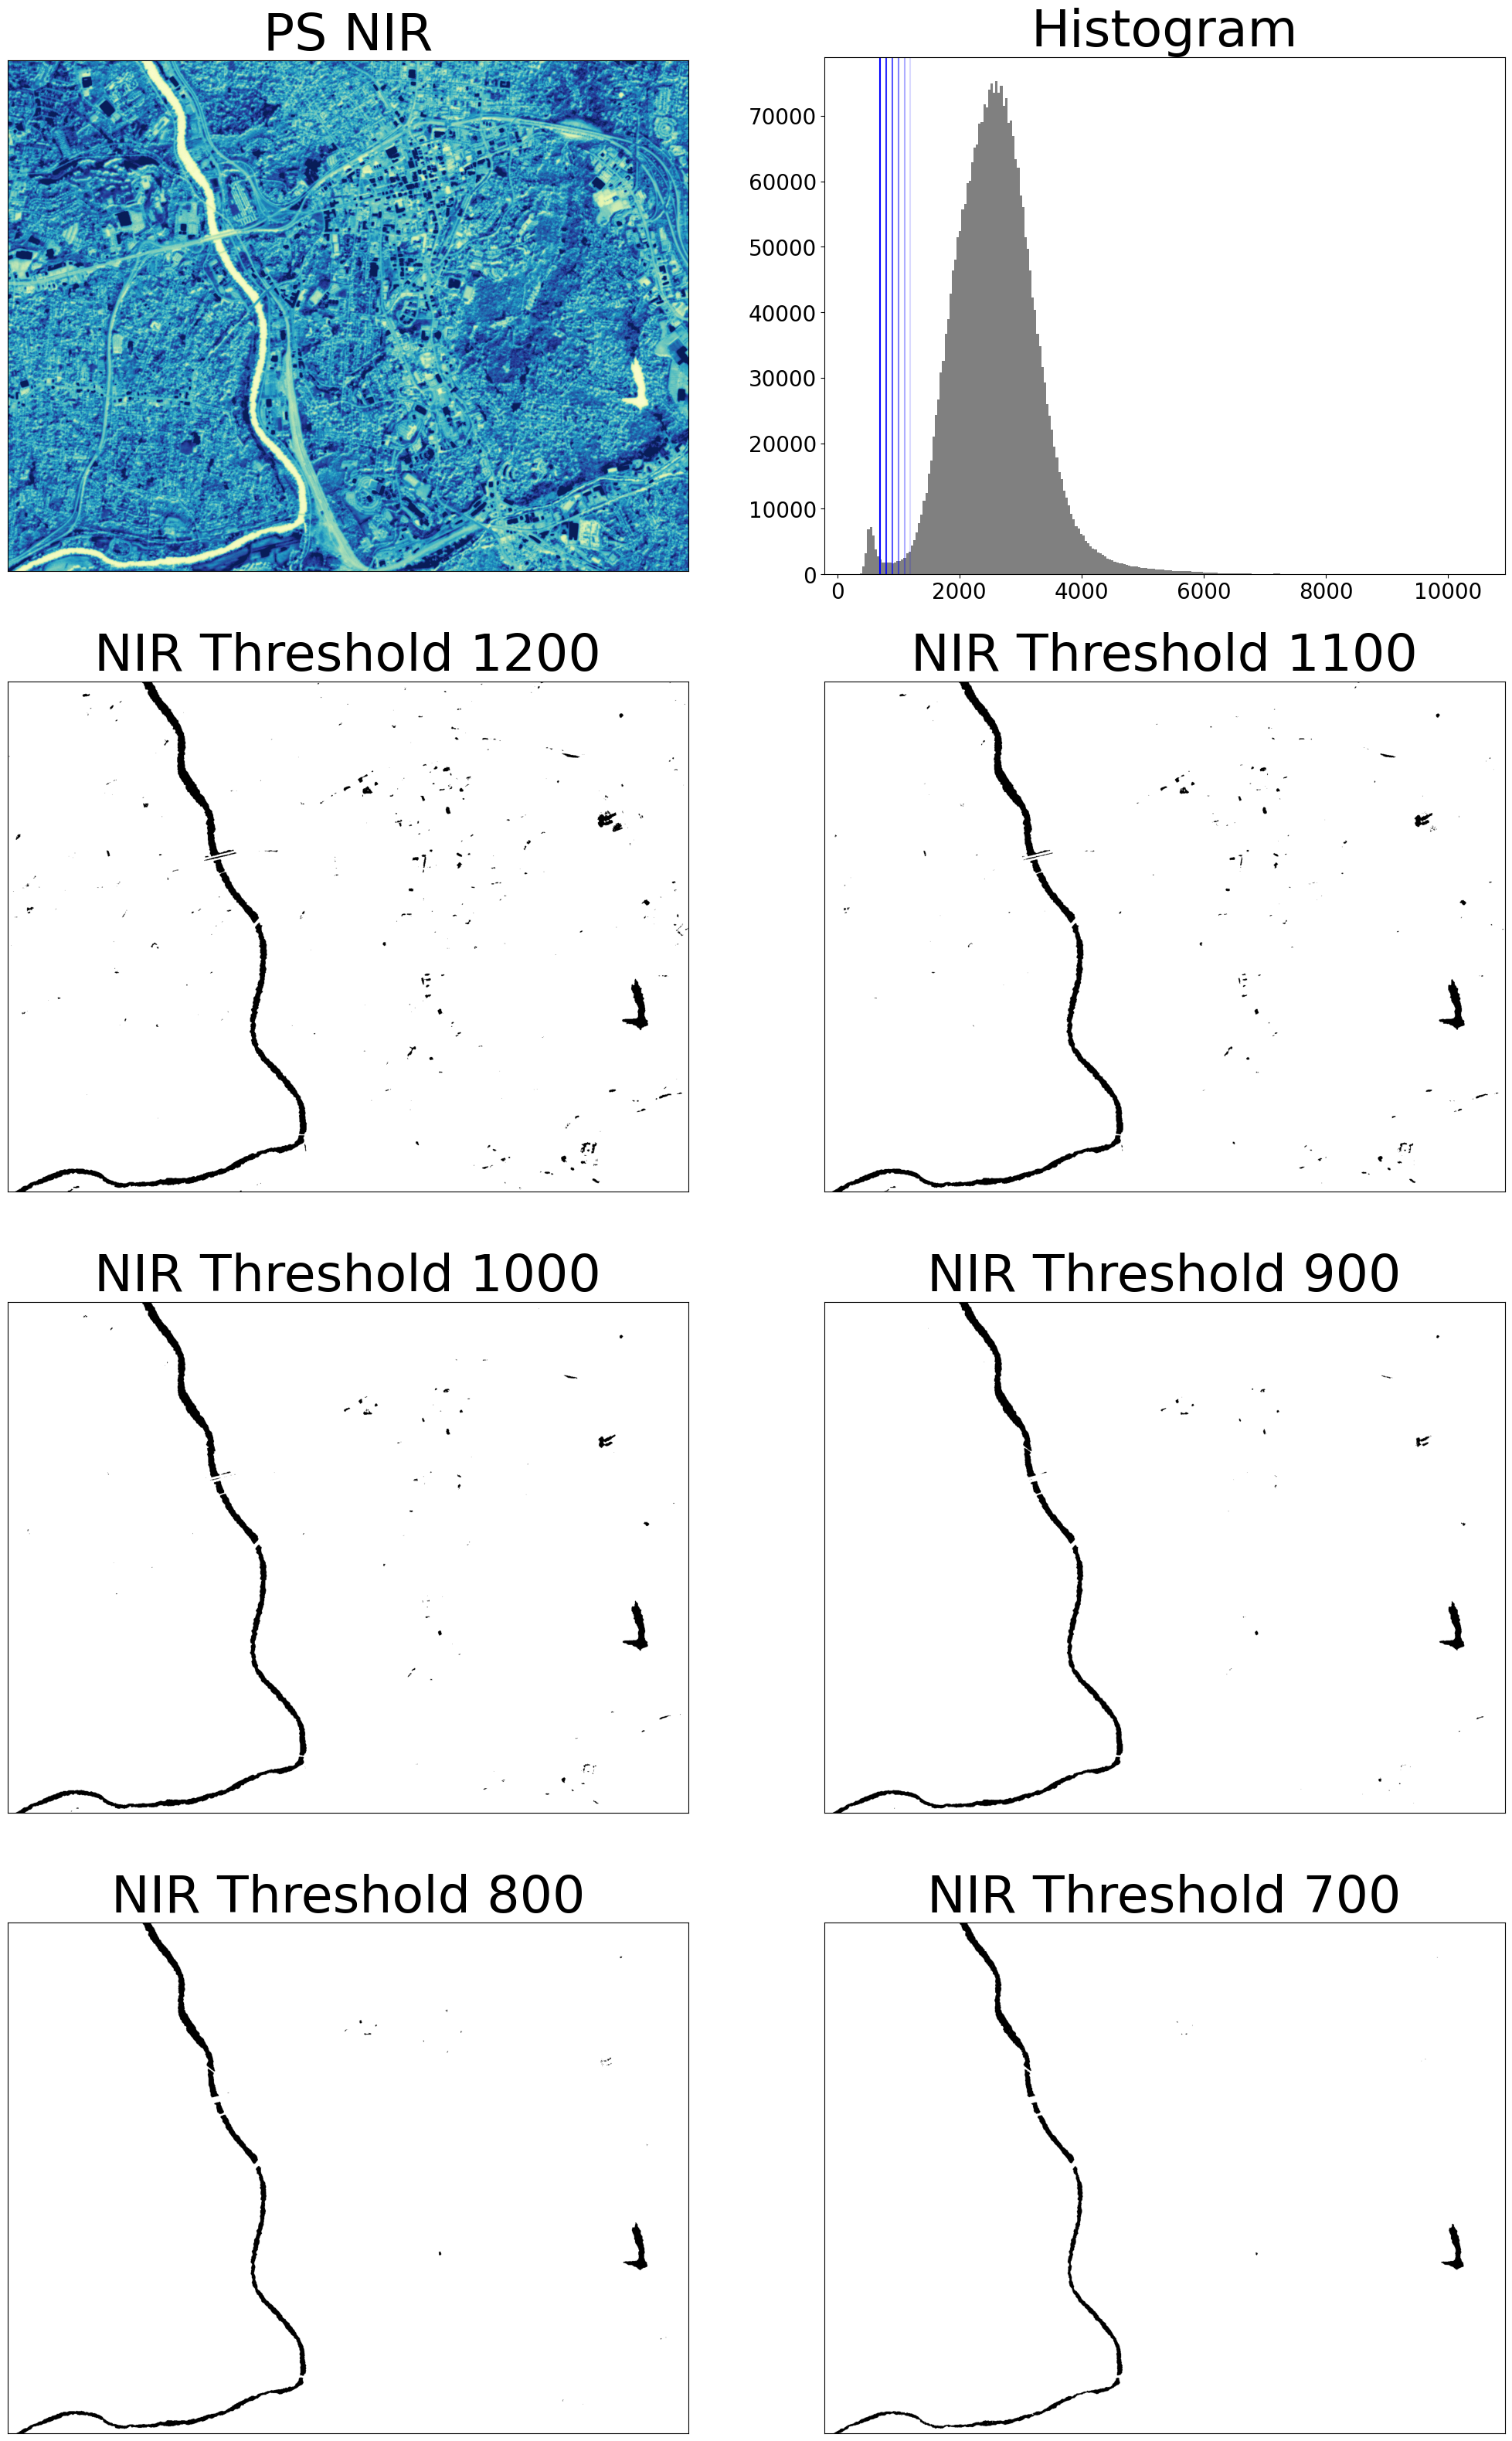

In [29]:

# My Threshold
PS_thresh_1200 = 1200
# Global Binary images
PS_binary_1200 = PS_stack[3] > PS_thresh_1200
PS_binary_1200 = PS_binary_1200.astype(int) #zeros or ones

# My Threshold
PS_thresh_1100 = 1100
# Global Binary images
PS_binary_1100 = PS_stack[3] > PS_thresh_1100
PS_binary_1100 = PS_binary_1100.astype(int) #zeros or ones

# My Threshold
PS_thresh_1000 = 1000
# Global Binary images
PS_binary_1000 = PS_stack[3] > PS_thresh_1000
PS_binary_1000 = PS_binary_1000.astype(int) #zeros or ones

# My Threshold
PS_thresh_900 = 900
# Global Binary images
PS_binary_900 = PS_stack[3] > PS_thresh_900
PS_binary_900 = PS_binary_900.astype(int) #zeros or ones

# My Threshold
PS_thresh_800 = 800
# Global Binary images
PS_binary_800 = PS_stack[3] > PS_thresh_800
PS_binary_800 = PS_binary_800.astype(int) #zeros or ones

# My Threshold
PS_thresh_700 = 700
# Global Binary images
PS_binary_700 = PS_stack[3] > PS_thresh_700
PS_binary_700 = PS_binary_700.astype(int) #zeros or ones


# Otsu Threshold
PS_otsu = threshold_otsu(PS_stack[3].values[~np.isnan(PS_stack[3])])
print(f'PS Otsu Threshold: {PS_otsu}')
# Global Binary images
PS_binary_otsu = PS_stack[3] > PS_otsu
PS_binary_otsu = PS_binary_otsu.astype(int) #zeros or ones

plt.rcParams.update({'font.size':40})

# Plotting images for 
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(25,40))

# create axis to subpot
ax = axes.ravel()
# ax[0] = plt.subplot(1, 3, 1,adjustable='box')
# ax[1] = plt.subplot(1, 3, 2)
# ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0],adjustable='box')
# ax[3] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0],adjustable='box')

# ep.plot_rgb(clipped_image.values,
#             rgb=[3, 2, 1],
#             ax=ax[0],
#             stretch=True,
#             title="False Color",
#             extent=ps_plotting_extent) 
# shp.plot(column='Class', ax=ax[0])

ax[0].imshow(PS_stack[3], cmap='YlGnBu', vmin=np.nanmin(PS_stack[3]), vmax=4000)
ax[0].set_title('PS NIR')
ax[0].xaxis.set_major_locator(ticker.NullLocator())
ax[0].yaxis.set_major_locator(ticker.NullLocator())

ax[1].hist(PS_stack[3].values.flatten() ,color = 'grey', bins=256)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_title('Histogram')
# ax[1].axvline(PS_otsu, color='r')
ax[1].axvline(PS_thresh_1200, color='b', alpha=0.15)
ax[1].axvline(PS_thresh_1100, color='b', alpha=0.32)
ax[1].axvline(PS_thresh_1000, color='b', alpha=0.49)
ax[1].axvline(PS_thresh_900, color='b', alpha=0.66)
ax[1].axvline(PS_thresh_800, color='b', alpha=0.83)
ax[1].axvline(PS_thresh_700, color='b', alpha=1)
# ax[2].annotate('Otsu threshold ={0}\nMy threshold ={1}'.format(str(round(PS_otsu,4)), str(round(PS_thresh_1200,4))), xy=(-0.35, 1E6))

# ax[3].imshow(PS_binary_otsu, cmap=plt.cm.gray)
# ax[3].set_title('Otsu Thresholded')
# ax[3].xaxis.set_major_locator(ticker.NullLocator())
# ax[3].yaxis.set_major_locator(ticker.NullLocator())

ax[2].imshow(PS_binary_1200, cmap=plt.cm.gray)
ax[2].set_title('NIR Threshold 1200')
ax[2].xaxis.set_major_locator(ticker.NullLocator())
ax[2].yaxis.set_major_locator(ticker.NullLocator())

ax[3].imshow(PS_binary_1100, cmap=plt.cm.gray)
ax[3].set_title('NIR Threshold 1100')
ax[3].xaxis.set_major_locator(ticker.NullLocator())
ax[3].yaxis.set_major_locator(ticker.NullLocator())

ax[4].imshow(PS_binary_1000, cmap=plt.cm.gray)
ax[4].set_title('NIR Threshold 1000')
ax[4].xaxis.set_major_locator(ticker.NullLocator())
ax[4].yaxis.set_major_locator(ticker.NullLocator())

ax[5].imshow(PS_binary_900, cmap=plt.cm.gray)
ax[5].set_title('NIR Threshold 900')
ax[5].xaxis.set_major_locator(ticker.NullLocator())
ax[5].yaxis.set_major_locator(ticker.NullLocator())

ax[6].imshow(PS_binary_800, cmap=plt.cm.gray)
ax[6].set_title('NIR Threshold 800')
ax[6].xaxis.set_major_locator(ticker.NullLocator())
ax[6].yaxis.set_major_locator(ticker.NullLocator())

ax[7].imshow(PS_binary_700, cmap=plt.cm.gray)
ax[7].set_title('NIR Threshold 700')
ax[7].xaxis.set_major_locator(ticker.NullLocator())
ax[7].yaxis.set_major_locator(ticker.NullLocator())

plt.show()

In [ ]:
shp.geometry.values

In [ ]:
# Extract geometry of each feature in shp in GeoJSON format
geoms = shp.geometry.values

# check one of the geometries
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] 
print(type(feature))
print(feature)

In [ ]:
# extract raster values within the polygon
from rasterio.mask import mask
out_image, out_transform = mask(ps_bands, feature, crop=True)
out_image.shape

In [ ]:
# close rasterio dataset
ps_bands.close()

In [ ]:
geoms[0]

#### Building Training Data for scikit-learn

In [ ]:
# Create array X with all the pixels and arary Y with training indicies
X = np.array([], dtype=np.int8).reshape(0,6) 
y = np.array([], dtype=np.int8) 

In [ ]:
PS = rio.open('./data/PS_stacked.tif')
PS.count
# band_count = src.count
# print(band_count)
    

In [ ]:
PS.read_band(1)

In [ ]:
# extract raster values within the polygon
with rio.open('./data/PS_stacked.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        # print(geom, shp['Class'][index])

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands (not part of the shapefile)
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands (not actually part of the shapefile)
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shp['Class'][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [ ]:
def upsample_water_pixels(x, y):

    non_water_len = np.unique(y, return_counts=True)[1][0]

    repetitions = non_water_len // np.unique(y, return_counts=True)[1][1]
    remainder = non_water_len % np.unique(y, return_counts=True)[1][1]

    duplicated_y = np.tile(np.where(y==1), repetitions)
    duplicated_x = np.tile(x[np.where(y==1)], repetitions)

    x = np.append(x, duplicated_x)
    y = np.append(y, duplicated_y)

    # if remainder > 0:
    #     duplicated_y = np.concatenate((duplicated_y, arr[:remainder]))
    
    return duplicated_y, x

In [ ]:
X

In [ ]:
y
np.unique(y, return_counts=True)

In [ ]:
y_new, X_new = upsample_water_pixels(X, y)
print(f"x: {len(X_new)}, y: {len(y_new)}, unique: {np.unique(y, return_counts=True)}")

In [ ]:
X_new



In [ ]:
# What are our classification indexes?
labels = np.unique(shp['Class'])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, classes=labels))
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Training RF classifier

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size = 0.25 >> i.e. 25% of the data; represents the proportion of the dataset to include in the test split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 8) 

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 8)
# Fit the model on training data
rf.fit(train_features, train_labels)

In [ ]:
class_pred = rf.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, class_pred)
plt.show()


In [ ]:
# Accuracy Score
print(accuracy_score(test_labels, class_pred))

In [ ]:
ps_bands = rio.open('./data/PS_stacked.tif')
ps_stack = ps_bands.read()

In [ ]:
# # Clip stack
# clipped_ps_stack = ps_stack[:, 2000:4000, 6000:9000]
# print(clipped_ps_stack.shape)

In [ ]:
from rasterio.plot import reshape_as_image
reshaped_ps_stack = reshape_as_image(ps_stack)
print(reshaped_ps_stack.shape, type(reshaped_ps_stack))

In [ ]:
ps_stack

In [ ]:
class_prediction = rf.predict(reshaped_ps_stack.reshape(-1,6))

In [ ]:
# Reshape our classificaiton map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_ps_stack[:,:,0].shape)

In [ ]:
class_prediction
np.unique(class_prediction, return_counts=True)

In [ ]:
class_prediction.shape

In [ ]:
# define function to stretch the color for better viz
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rio.plot.adjust_band(colors[:, :, b])
    return colors

In [ ]:
# Let's look at the results
fig, axs = plt.subplots(1,2,figsize=(10,8))

img_stretched = color_stretch(reshaped_ps_stack, [3,2,1])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction)